### Задача 1

Так как специалисту по машинному обучению часто приходится сталкиваться с различными API и их документацией необходимо уметь с этим работать.
В рамках задачи нужно используя документацию https://yandex.ru/dev/direct/ получить токен песочницы написать на Python код собирающий данные по рекламным кампаниям Яндекс директ.

Для выполнения поставленного задания были совершены следующие шаги: 
* зарегистрирован аккаунт в Директе и принято пользовательское соглашение в разделе API веб-интерфейса Директа.
* зарегистрировано приложение на Яндекс.OAuth.
* подана заявка на доступ к API и получено одобрение заявки.
* получен OAuth-токен.
* включена Песочница.

Код, представленный ниже, является скриптом для получения токена пользователя. 
Приложение должно быть запущено на публичном IP-адресе. Доменное имя, связанное с этим IP-адресом, нужно указать как Redirect URI нашего приложения. 
Таким образом, первое обращение к нашему адресу будет направлять на страницу запроса доступа. 
После получения доступа, зарегестрированное нами приложение, будет редиректить нас на указанный адрес с добавлением аргумента полученого кода.
Отработает условие `request.args.get('code')` и будет выполнен запрос для получения токена.

Данный процесс можно выполнить локально, запустив скрипт, получив код для запроса доступа и самим подставить его в аргумент ссылки. 
Или воспользоваться отладачным токеном.

In [ ]:
from flask import Flask, request, jsonify, redirect
from requests import post

# Метод для кодирования URL как в Python 3, так и в Python 2
import sys

if sys.version_info < (3, 0):  # Pytohn2.x
    from urllib import urlencode
else:  # Python3.x
    from urllib.parse import urlencode

# Идентификатор приложения
client_id = '...'
# Пароль приложения
client_secret = '...'
# Адрес сервера Яндекс.OAuth
baseurl = 'https://oauth.yandex.ru/'

app = Flask(__name__)


@app.route('/')
def index():
    if request.args.get('code', False):
        # Если скрипт был вызван с указанием параметра "code" в URL,
        # то выполняется запрос на получение токена
        print(request.args)
        print(request.data)
        data = {
            'grant_type': 'authorization_code',
            'code': request.args.get('code'),
            'client_id': client_id,
            'client_secret': client_secret
        }
        data = urlencode(data)
        # Токен необходимо сохранить для использования в запросах к API Директа
        return jsonify(post(baseurl + "token", data).json())
    else:
        # Если скрипт был вызван без указания параметра "code",
        # то пользователь перенаправляется на страницу запроса доступа
        return redirect(baseurl + "authorize?response_type=code&client_id={}".format(client_id))


if __name__ == '__main__':
    # Отладочная информация
    # app.debug = True
    # Запуск веб-сервера с доступом по порту 8000
    app.run(host='127.0.0.1', port=8000)

In [ ]:
# -*- coding: utf-8 -*-
import requests, json
from requests.exceptions import ConnectionError
from time import sleep

#  Метод для корректной обработки строк в кодировке UTF-8 как в Python 3, так и в Python 2
import sys

if sys.version_info < (3,):
    def u(x):
        try:
            return x.encode("utf8")
        except UnicodeDecodeError:
            return x
else:
    def u(x):
        if type(x) == type(b''):
            return x.decode('utf8')
        else:
            return x

# --- Входные данные ---
#  Адрес сервиса Campaigns для отправки JSON-запросов (регистрозависимый)
CampaignsURL = 'https://api.direct.yandex.com/json/v5/campaigns'

# OAuth-токен пользователя, от имени которого будут выполняться запросы
token = '...'

# Логин клиента рекламного агентства
# Обязательный параметр, если запросы выполняются от имени рекламного агентства
#clientLogin = 'ЛОГИН_КЛИЕНТА'

# --- Подготовка, выполнение и обработка запроса ---
#  Создание HTTP-заголовков запроса
headers = {"Authorization": "Bearer " + token,  # OAuth-токен. Использование слова Bearer обязательно
           "Accept-Language": "ru",  # Язык ответных сообщений
           }

# Создание тела запроса
body = {"method": "get",  # Используемый метод.
        "params": {"SelectionCriteria": {},  # Критерий отбора кампаний. Для получения всех кампаний должен быть пустым
                   "FieldNames": ["Id", "Name"]  # Имена параметров, которые требуется получить.
                   }}

# Кодирование тела запроса в JSON
jsonBody = json.dumps(body, ensure_ascii=False).encode('utf8')

# Выполнение запроса
try:
    result = requests.post(CampaignsURL, jsonBody, headers=headers)

    # Отладочная информация
    # print("Заголовки запроса: {}".format(result.request.headers))
    # print("Запрос: {}".format(u(result.request.body)))
    # print("Заголовки ответа: {}".format(result.headers))
    # print("Ответ: {}".format(u(result.text)))
    # print("\n")

    # Обработка запроса
    if result.status_code != 200 or result.json().get("error", False):
        print("Произошла ошибка при обращении к серверу API Директа.")
        print("Код ошибки: {}".format(result.json()["error"]["error_code"]))
        print("Описание ошибки: {}".format(u(result.json()["error"]["error_detail"])))
        print("RequestId: {}".format(result.headers.get("RequestId", False)))
    else:
        print("RequestId: {}".format(result.headers.get("RequestId", False)))
        print("Информация о баллах: {}".format(result.headers.get("Units", False)))
        # Вывод списка кампаний
        for campaign in result.json()["result"]["Campaigns"]:
            print("Рекламная кампания: {} №{}".format(u(campaign['Name']), campaign['Id']))

        if result.json()['result'].get('LimitedBy', False):
            # Если ответ содержит параметр LimitedBy, значит,  были получены не все доступные объекты.
            # В этом случае следует выполнить дополнительные запросы для получения всех объектов.
            # Подробное описание постраничной выборки - https://tech.yandex.ru/direct/doc/dg/best-practice/get-docpage/#page
            print("Получены не все доступные объекты.")


# Обработка ошибки, если не удалось соединиться с сервером API Директа
except ConnectionError:
    # В данном случае мы рекомендуем повторить запрос позднее
    print("Произошла ошибка соединения с сервером API.")

# Если возникла какая-либо другая ошибка
except:
    # В данном случае мы рекомендуем проанализировать действия приложения
    print("Произошла непредвиденная ошибка.")

### Задача 2

Базовое знание XML полезно для работы, так как в данном формате происходит обмен информацией между внешними источниками и системой принятия решений. В рамках задачи необходимо написать код, получающий информацию о каталоге CD дисков с адреса https://www.w3schools.com/xml/cd_catalog.xml .

Напишите код, который:

1)         Считает стоимость всех дисков в каталоге.

2)         Какой год для дисков в каталоге является последним (самым современным)

3)         Компания «Polydor» сменила своё название на «Poly», измените название этой компании у всех CD на актуальное в XML каталоге и сохраните новый XML файл

In [80]:
import xml.etree.ElementTree as ET

In [81]:
tree = ET.parse('w3schools.com_xml_cd_catalog.xml')

In [82]:
root = tree.getroot()
display(root)

<Element 'CATALOG' at 0x10595b240>

In [83]:
display(list(root[1]))

[<Element 'TITLE' at 0x105965210>,
 <Element 'ARTIST' at 0x1059651c0>,
 <Element 'COUNTRY' at 0x105965120>,
 <Element 'COMPANY' at 0x105964090>,
 <Element 'PRICE' at 0x105964040>,
 <Element 'YEAR' at 0x1059640e0>]

Задание 2.1.

In [84]:
sum = 0
for cd in root:
    #print(cd[4].tag, cd[4].text)
    sum += float(cd[4].text)
print()
print('Cтоимость всех дисков в каталоге составляет', round(sum))


Cтоимость всех дисков в каталоге составляет 237


Задание 2.2.

In [85]:
latest_year = 0
for cd in root:
    #print(cd[5].tag, cd[5].text)
    if int(cd[5].text) > latest_year:
        latest_year = int(cd[5].text)
print(latest_year, 'год для дисков в каталоге является последним (самым современным)')


1999 год для дисков в каталоге является последним (самым современным)


Задание 2.3.

In [86]:
for cd in root:
    #print(cd[3].tag, cd[3].text)
    if cd[3].text == 'Polydor':
        cd[3].text = 'Poly'
print()

In [87]:
ET.ElementTree(root).write('new_cd_catalog.xml', encoding="utf-8")

Изменено название компании «Polydor» на «Poly» у всех CD в XML каталоге и сохранен новый XML файл new_cd_catalog.xml.

### Задача 3 - OLAP БД Сlickhouse

*Базовой библиотекой для clickhouse является clickhouse-connect, поэтому предполагается использование данного коннектора*

In [73]:
import clickhouse_connect
from clickhouse_connect.driver import Client as ClickHouseClient
import pandas as pd

client:ClickHouseClient = clickhouse_connect.get_client(host='play.clickhouse.com',
                                           username='play',
                                           password='clickhouse',
                                           database='default',
                                           secure=True,
                                           port=443)

# тестовые данные playground clickhouse совпадают не полностью, но являются данными похожими на hits метрики https://yandex.ru/dev/metrika/doc/api2/logs/fields/hits.html
client.query_df('DESCRIBE TABLE default.hits')

,name,type,default_type,default_expression,comment,codec_expression,ttl_expression
0,WatchID,UInt64,,,,,
1,JavaEnable,UInt8,,,,,
2,Title,String,,,,,
3,GoodEvent,Int16,,,,,
4,EventTime,DateTime,,,,,
5,EventDate,Date,,,,,
6,CounterID,UInt32,,,,,
7,ClientIP,UInt32,,,,,
8,RegionID,UInt32,,,,,
9,UserID,UInt64,,,,,


##### Так как "hits" хранит каждую просмотренную страницу и может содержать сотни миллионов записей, необходимо использовать SQL запросы для ответа на некоторые базовые вопросы.

In [74]:
### Пример запроса, количество записей в таблице
sql = '''
SELECT count(*) as cnt
FROM default.hits
'''

client.query_df(sql)

,cnt
0,100000000


**Мы подразумеваем, что WatchID уникален, так ли это?**

In [75]:
sql = '''
SELECT COUNT(WatchID)
FROM default.hits
'''

client.query_df(sql)

,count(WatchID)
0,100000000


In [76]:
sql = '''
SELECT COUNT (DISTINCT WatchID)
FROM default.hits
'''

client.query_df(sql)

,uniqExact(WatchID)
0,99997493


In [77]:
sql = '''
SELECT WatchID, COUNT (*)
FROM default.hits
GROUP BY WatchID
HAVING COUNT (*) > 1
'''

client.query_df(sql)

,WatchID,count()
0,6471985135199404171,2
1,5449473658271472229,2
2,7276808508472766734,2
3,7868773087760090206,2
4,6715066792220766396,2
...,...,...
1002,5195528859626946876,2
1003,5358723063902114389,2
1004,4910010153134720840,2
1005,6002700632667857041,2


В результате запросов выше можно сделать вывод о том, что атрибут WatchID не уникален.

**Сколько просмотров в среднем делает каждый юзер?**

In [78]:
sql = '''
SELECT AVG(cnt)
FROM(
SELECT UserID, COUNT(WatchID) as cnt
FROM default.hits
GROUP BY UserID
ORDER BY 2 DESC
)
'''

client.query_df(sql)

,avg(cnt)
0,5.671836


**Сильно ли отличается количество средних просмотров по счётчикам?**

In [79]:
sql = '''
SELECT AVG(cnt)
FROM(
SELECT CounterID, COUNT(WatchID) as cnt
FROM default.hits
GROUP BY CounterID
ORDER BY 2 DESC
)
'''

client.query_df(sql)

,avg(cnt)
0,15370.427298


Как видно из запросов выше количество средних просмотров по счётчикам в сравнии с пользователями отличается сильно.

### Задача 4

**Часть хитов помечены как DontCountHits в таблице default.hits, от каких показателей это зависит? Меняется ли данный показатель во времени?**

Можно пользоваться моделями, корреляцией и другими инструментами, которые могут помочь в ответе на данный вопрос


In [3]:
import clickhouse_connect
from clickhouse_connect.driver import Client as ClickHouseClient
import pandas as pd

client:ClickHouseClient = clickhouse_connect.get_client(host='play.clickhouse.com',
                                           username='play',
                                           password='clickhouse',
                                           database='default',
                                           secure=True,
                                           port=443)

# тестовые данные playground clickhouse совпадают не полностью, но являются данными похожими на hits метрики https://yandex.ru/dev/metrika/doc/api2/logs/fields/hits.html
client.query_df('DESCRIBE TABLE default.hits')

,name,type,default_type,default_expression,comment,codec_expression,ttl_expression
0,WatchID,UInt64,,,,,
1,JavaEnable,UInt8,,,,,
2,Title,String,,,,,
3,GoodEvent,Int16,,,,,
4,EventTime,DateTime,,,,,
...,...,...,...,...,...,...,...
100,FromTag,String,,,,,
101,HasGCLID,UInt8,,,,,
102,RefererHash,UInt64,,,,,
103,URLHash,UInt64,,,,,


In [108]:
import pandas as pd
import numpy as np
from datetime import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [24]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [25]:
sql = '''
SELECT DontCountHits, COUNT(*)
FROM default.hits
GROUP BY DontCountHits
'''

client.query_df(sql)

,DontCountHits,count()
0,0,90579093
1,1,9420907


In [18]:
sql = '''
SELECT *
FROM default.hits
'''

data = client.query_df(sql)

In [23]:
data['DontCountHits'].nunique()

2

In [26]:
data.nunique().sort_values()

CLID                        1
ParamPrice                  1
SocialSourceNetworkID       1
HTTPError                   1
SocialAction                1
SocialNetwork               1
OpenerName                  1
ParamOrderID                1
WithHash                    1
IsEvent                     1
CookieEnable                1
JavascriptEnable            1
IsOldCounter                1
Params                      1
SilverlightVersion4         1
IsParameter                 1
ParamCurrency               1
SocialSourcePage            1
OpenstatServiceName         1
HasGCLID                    1
FromTag                     1
GoodEvent                   1
UTMTerm                     1
EventDate                   1
ParamCurrencyID             1
CounterID                   1
CounterClass                1
OpenstatSourceID            1
OpenstatAdID                1
OpenstatCampaignID          1
AdvEngineID                 1
UTMCampaign                 2
DontCountHits               2
UTMContent

In [27]:
# создадим список признаков, в которых только одно уникальное значение
features_list = []
for i in data.columns:
    if data[i].nunique() == 1:
        features_list.append(i)

print(features_list)

['GoodEvent', 'EventDate', 'CounterID', 'CounterClass', 'CookieEnable', 'JavascriptEnable', 'Params', 'AdvEngineID', 'SilverlightVersion4', 'IsOldCounter', 'IsEvent', 'IsParameter', 'WithHash', 'OpenerName', 'SocialNetwork', 'SocialAction', 'HTTPError', 'SocialSourceNetworkID', 'SocialSourcePage', 'ParamPrice', 'ParamOrderID', 'ParamCurrency', 'ParamCurrencyID', 'OpenstatServiceName', 'OpenstatCampaignID', 'OpenstatAdID', 'OpenstatSourceID', 'UTMTerm', 'FromTag', 'HasGCLID', 'CLID']


In [28]:
# удалим признаки с одним уникальным значением ввиду отсутствия информативности и ценности при моделировании
data = data.drop(columns=features_list)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 74 columns):
 #   Column               Non-Null Count  Dtype                  
---  ------               --------------  -----                  
 0   WatchID              8192 non-null   uint64                 
 1   JavaEnable           8192 non-null   uint8                  
 2   Title                8192 non-null   string                 
 3   EventTime            8192 non-null   datetime64[ns, Etc/UTC]
 4   ClientIP             8192 non-null   uint32                 
 5   RegionID             8192 non-null   uint32                 
 6   UserID               8192 non-null   uint64                 
 7   OS                   8192 non-null   uint8                  
 8   UserAgent            8192 non-null   uint8                  
 9   URL                  8192 non-null   string                 
 10  Referer              8192 non-null   string                 
 11  Refresh              8192 non-

In [30]:
data.nunique().sort_values()

IsArtifical               2
SilverlightVersion2       2
IsMobile                  2
CodeVersion               2
NetMinor                  2
IsLink                    2
IsDownload                2
URLCategoryID             2
UTMMedium                 2
Refresh                   2
IsNotBounce               2
UTMCampaign               2
JavaEnable                2
UTMSource                 2
UTMContent                2
DontCountHits             2
PageCharset               3
FlashMajor                3
HitColor                  3
Sex                       3
ResolutionDepth           3
NetMajor                  3
Income                    4
SilverlightVersion1       4
MobilePhoneModel          4
URLRegionID               5
BrowserCountry            5
Age                       6
TraficSourceID            6
BrowserLanguage           7
FlashMinor                9
MobilePhone               9
RefererCategoryID        11
SearchEngineID           11
ClientTimeZone           13
UserAgent           

In [31]:
# удаление текстовых малоинформативных столбцов, так как большинство моделей ML не умеют работать с текстовыми данными
data = data.drop(columns=['Title', 'URL', 'Referer', 'SearchPhrase', 'UserAgentMinor'])

In [32]:
data.shape

(8192, 69)

In [33]:
print(data['LocalEventTime'].max())
print(data['LocalEventTime'].min())

2013-07-28 19:59:55+00:00
2013-07-27 20:00:09+00:00


Временной интервал рассматривается в рамках июля 2013 года, таким образом можно извлечь дату из формата datetime

In [35]:
data['EventTime'] = pd.to_datetime(data['EventTime']).dt.time
data['ClientEventTime'] = pd.to_datetime(data['ClientEventTime']).dt.time
data['LocalEventTime'] = pd.to_datetime(data['LocalEventTime']).dt.time

In [36]:
# функция кодировки признаков datetime в вид: 1 — утро, 2 — день, 3 — вечер, 4 — ночь.

def time_coding(x):
    if time.fromisoformat('06:00:00') <= x < time.fromisoformat('12:00:00'):
        return(int(1))  # morning
    elif time.fromisoformat('12:00:00') <= x < time.fromisoformat('18:00:00'):
        return(int(2))  # day
    elif time.fromisoformat('18:00:00') <= x < time.fromisoformat('23:00:00'):
        return(int(3))  #evening
    else:
        return(int(4))  # night

In [37]:
data['EventTime_coding'] = data['EventTime'].apply(time_coding)
data['ClientEventTime_coding'] = data['ClientEventTime'].apply(time_coding)
data['LocalEventTime_coding'] = data['LocalEventTime'].apply(time_coding)

In [38]:
data = data.drop(columns=['EventTime', 'ClientEventTime', 'LocalEventTime'])

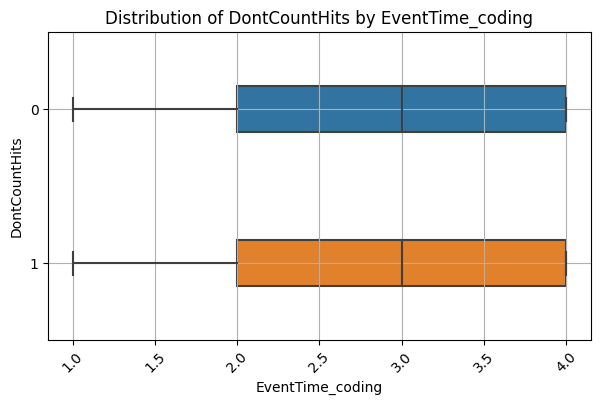

In [39]:
fig = plt.figure(figsize=(7, 4))
boxplot = sns.boxplot(data=data, x="EventTime_coding", y="DontCountHits", orient='h', width=0.3)
boxplot.set_title('Distribution of DontCountHits by EventTime_coding');
boxplot.set_xlabel('EventTime_coding');
boxplot.set_ylabel('DontCountHits');
boxplot.grid();
plt.xticks(rotation=45);


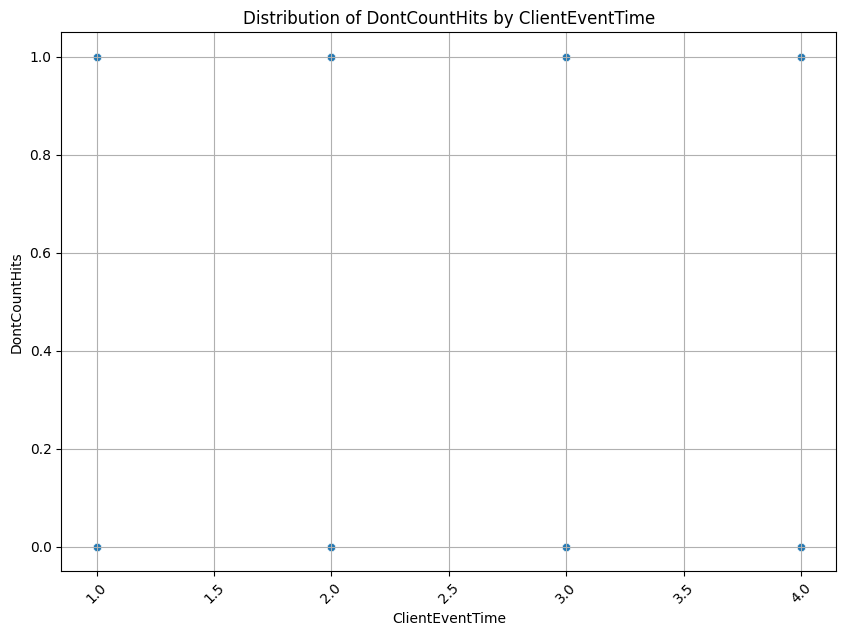

In [40]:
fig = plt.figure(figsize=(10, 7))
scatterplot = sns.scatterplot(data=data, x="ClientEventTime_coding", y="DontCountHits")
scatterplot.set_title('Distribution of DontCountHits by ClientEventTime');
scatterplot.set_xlabel('ClientEventTime');
scatterplot.set_ylabel('DontCountHits');
scatterplot.grid();
plt.xticks(rotation=45);


Признак DontCountHits не зависит от времени.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 69 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   WatchID                 8192 non-null   uint64
 1   JavaEnable              8192 non-null   uint8 
 2   ClientIP                8192 non-null   uint32
 3   RegionID                8192 non-null   uint32
 4   UserID                  8192 non-null   uint64
 5   OS                      8192 non-null   uint8 
 6   UserAgent               8192 non-null   uint8 
 7   Refresh                 8192 non-null   uint8 
 8   RefererCategoryID       8192 non-null   uint16
 9   RefererRegionID         8192 non-null   uint32
 10  URLCategoryID           8192 non-null   uint16
 11  URLRegionID             8192 non-null   uint32
 12  ResolutionWidth         8192 non-null   uint16
 13  ResolutionHeight        8192 non-null   uint16
 14  ResolutionDepth         8192 non-null   uint8 
 15  Flas

In [42]:
data['FlashMinor2'] = pd.to_numeric(data['FlashMinor2'])

In [43]:
def func(x):
    if x == 'iPad' or x == 'iPhone':
        return x
    else:
        return np.nan

data['MobilePhoneModel'] = data['MobilePhoneModel'].apply(func)

In [44]:
def func(x):
    if x == 'windows':
        return x
    else:
        return np.nan

data['PageCharset'] = data['PageCharset'].apply(func)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 69 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   WatchID                 8192 non-null   uint64 
 1   JavaEnable              8192 non-null   uint8  
 2   ClientIP                8192 non-null   uint32 
 3   RegionID                8192 non-null   uint32 
 4   UserID                  8192 non-null   uint64 
 5   OS                      8192 non-null   uint8  
 6   UserAgent               8192 non-null   uint8  
 7   Refresh                 8192 non-null   uint8  
 8   RefererCategoryID       8192 non-null   uint16 
 9   RefererRegionID         8192 non-null   uint32 
 10  URLCategoryID           8192 non-null   uint16 
 11  URLRegionID             8192 non-null   uint32 
 12  ResolutionWidth         8192 non-null   uint16 
 13  ResolutionHeight        8192 non-null   uint16 
 14  ResolutionDepth         8192 non-null   

In [46]:
columns_to_code = []
for i in data.columns:
    if data[i].dtype == object:
        columns_to_code.append(i)
columns_to_code

['MobilePhoneModel',
 'PageCharset',
 'HitColor',
 'BrowserLanguage',
 'BrowserCountry']

In [47]:
# кодировка признаков типа object
one_hot_encoder = OneHotEncoder()
 
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(data[columns_to_code]).toarray()

# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names_out(columns_to_code)
print(column_names)

['MobilePhoneModel_iPad' 'MobilePhoneModel_iPhone' 'MobilePhoneModel_nan'
 'PageCharset_windows' 'PageCharset_nan' "HitColor_b'5'" "HitColor_b'6'"
 "HitColor_b'g'" "BrowserLanguage_b'E3'" "BrowserLanguage_b'QJ'"
 "BrowserLanguage_b'S0'" "BrowserLanguage_b'Sv'" "BrowserLanguage_b'oz'"
 "BrowserLanguage_b'vG'" "BrowserLanguage_b'\\xf4\\xd5'"
 "BrowserCountry_b'1b'" "BrowserCountry_b'XR'" "BrowserCountry_b'_i'"
 "BrowserCountry_b'h1'" "BrowserCountry_b'\\xd0\\x0c'"]


In [48]:
data_onehot = pd.DataFrame(data_onehot, index=data.index, columns=column_names)
data_new = pd.concat([data, data_onehot], axis=1)

In [49]:
data_new = data_new.drop(columns=columns_to_code)

In [50]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 84 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   WatchID                      8192 non-null   uint64 
 1   JavaEnable                   8192 non-null   uint8  
 2   ClientIP                     8192 non-null   uint32 
 3   RegionID                     8192 non-null   uint32 
 4   UserID                       8192 non-null   uint64 
 5   OS                           8192 non-null   uint8  
 6   UserAgent                    8192 non-null   uint8  
 7   Refresh                      8192 non-null   uint8  
 8   RefererCategoryID            8192 non-null   uint16 
 9   RefererRegionID              8192 non-null   uint32 
 10  URLCategoryID                8192 non-null   uint16 
 11  URLRegionID                  8192 non-null   uint32 
 12  ResolutionWidth              8192 non-null   uint16 
 13  ResolutionHeight  

In [51]:
cols_null_percent = data_new.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

FlashMinor2    12.805176
dtype: float64

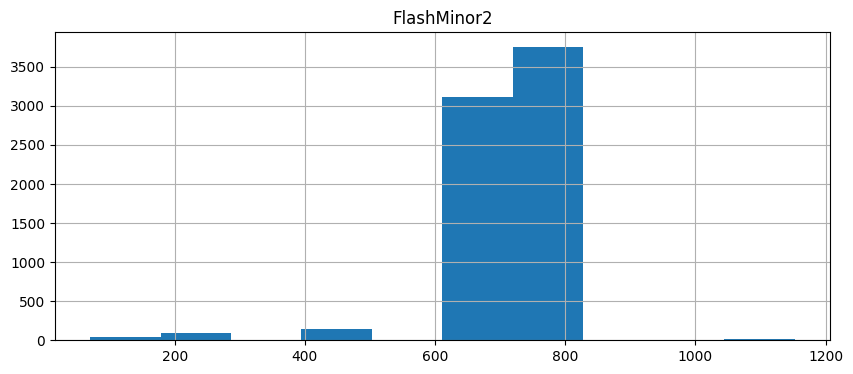

In [52]:
cols = cols_with_null.index
data_new[cols].hist(figsize=(10, 4));

In [53]:
data_new = data_new.fillna({'FlashMinor2': data_new['FlashMinor2'].mode()[0]})
data_new.isnull().mean()  # выводим результирующую долю пропусков

WatchID                        0.0
JavaEnable                     0.0
ClientIP                       0.0
RegionID                       0.0
UserID                         0.0
OS                             0.0
UserAgent                      0.0
Refresh                        0.0
RefererCategoryID              0.0
RefererRegionID                0.0
URLCategoryID                  0.0
URLRegionID                    0.0
ResolutionWidth                0.0
ResolutionHeight               0.0
ResolutionDepth                0.0
FlashMajor                     0.0
FlashMinor                     0.0
FlashMinor2                    0.0
NetMajor                       0.0
NetMinor                       0.0
UserAgentMajor                 0.0
IsMobile                       0.0
MobilePhone                    0.0
IPNetworkID                    0.0
TraficSourceID                 0.0
SearchEngineID                 0.0
IsArtifical                    0.0
WindowClientWidth              0.0
WindowClientHeight  

In [66]:
for col in ['UTMSource', 'UTMMedium', 'UTMCampaign', 'UTMContent']:
    print(data_new[col].value_counts())

           8190
admitad       2
Name: UTMSource, dtype: Int64
         8190
30533       2
Name: UTMMedium, dtype: Int64
                   8190
ad_cpamarketing       2
Name: UTMCampaign, dtype: Int64
                 8190
adPlus: Антон       2
Name: UTMContent, dtype: Int64


In [67]:
data_new = data_new.drop(columns=['UTMSource', 'UTMMedium', 'UTMCampaign', 'UTMContent'])

/var/folders/8_/y936460960110gnpk46t3fw00000gn/T/ipykernel_67710/2989298388.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_new.corr(), linewidths= .3, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')


<AxesSubplot: >

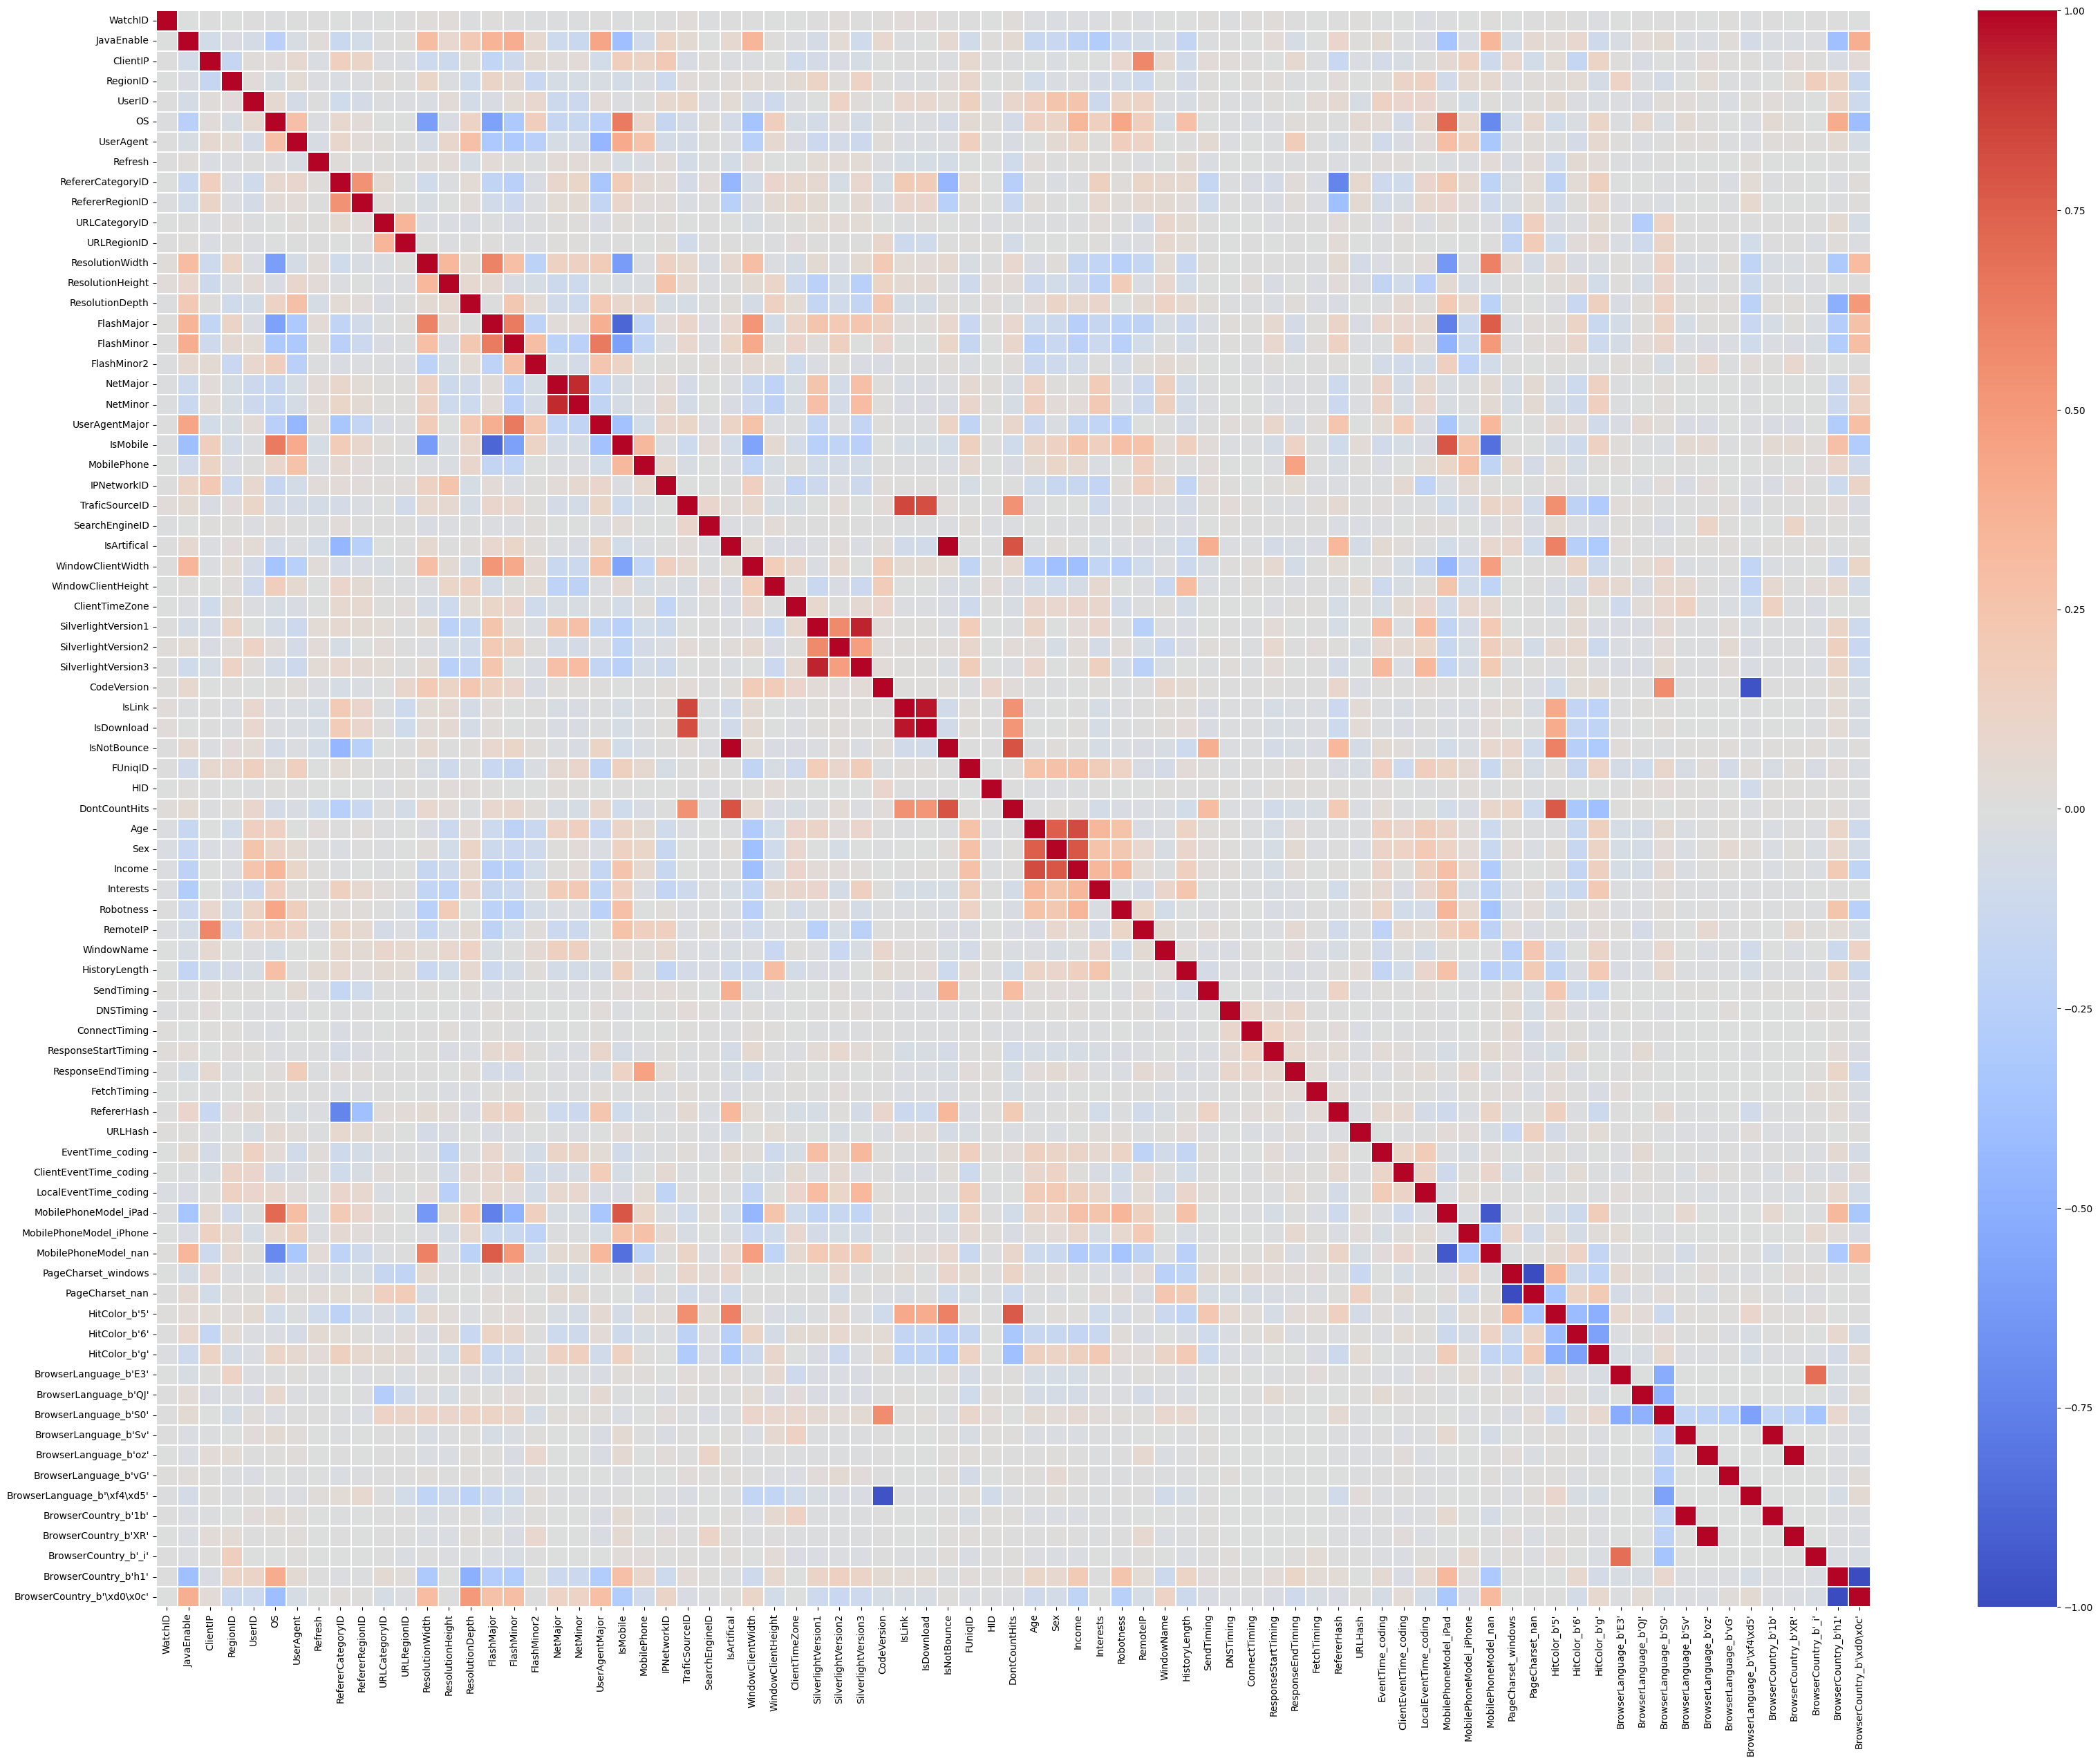

In [113]:
# проверка на мультиколлинеарность, которая может ухудшать качество моделирования
fig, ax = plt.subplots(figsize=(40, 30))
sns.heatmap(data_new.corr(), linewidths= .3, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [94]:
data_new.columns

Index(['WatchID', 'JavaEnable', 'ClientIP', 'RegionID', 'UserID', 'OS',
       'UserAgent', 'Refresh', 'RefererCategoryID', 'RefererRegionID',
       'URLCategoryID', 'URLRegionID', 'ResolutionWidth', 'ResolutionHeight',
       'ResolutionDepth', 'FlashMajor', 'FlashMinor', 'FlashMinor2',
       'NetMajor', 'NetMinor', 'UserAgentMajor', 'IsMobile', 'MobilePhone',
       'IPNetworkID', 'TraficSourceID', 'SearchEngineID', 'IsArtifical',
       'WindowClientWidth', 'WindowClientHeight', 'ClientTimeZone',
       'SilverlightVersion1', 'SilverlightVersion2', 'SilverlightVersion3',
       'CodeVersion', 'IsLink', 'IsDownload', 'IsNotBounce', 'FUniqID',
       'OriginalURL', 'HID', 'DontCountHits', 'Age', 'Sex', 'Income',
       'Interests', 'Robotness', 'RemoteIP', 'WindowName', 'HistoryLength',
       'SendTiming', 'DNSTiming', 'ConnectTiming', 'ResponseStartTiming',
       'ResponseEndTiming', 'FetchTiming', 'RefererHash', 'URLHash',
       'EventTime_coding', 'ClientEventTime_coding', 'Lo

In [154]:
df = data_new.drop(columns=['OS', 'RefererCategoryID', 'ResolutionWidth', 'FlashMajor', 'IsMobile', 'MobilePhoneModel_iPad', 'MobilePhoneModel_nan', 'CodeVersion', 'PageCharset_nan', "BrowserCountry_b'h1'", "BrowserLanguage_b'S0'", "HitColor_b'g'", 'IsArtifical', "BrowserCountry_b'XR'", "BrowserCountry_b'1b'", 'NetMajor', 'NetMinor', 'IsDownload'])

/var/folders/8_/y936460960110gnpk46t3fw00000gn/T/ipykernel_67710/3360083656.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), linewidths= .3, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')


<AxesSubplot: >

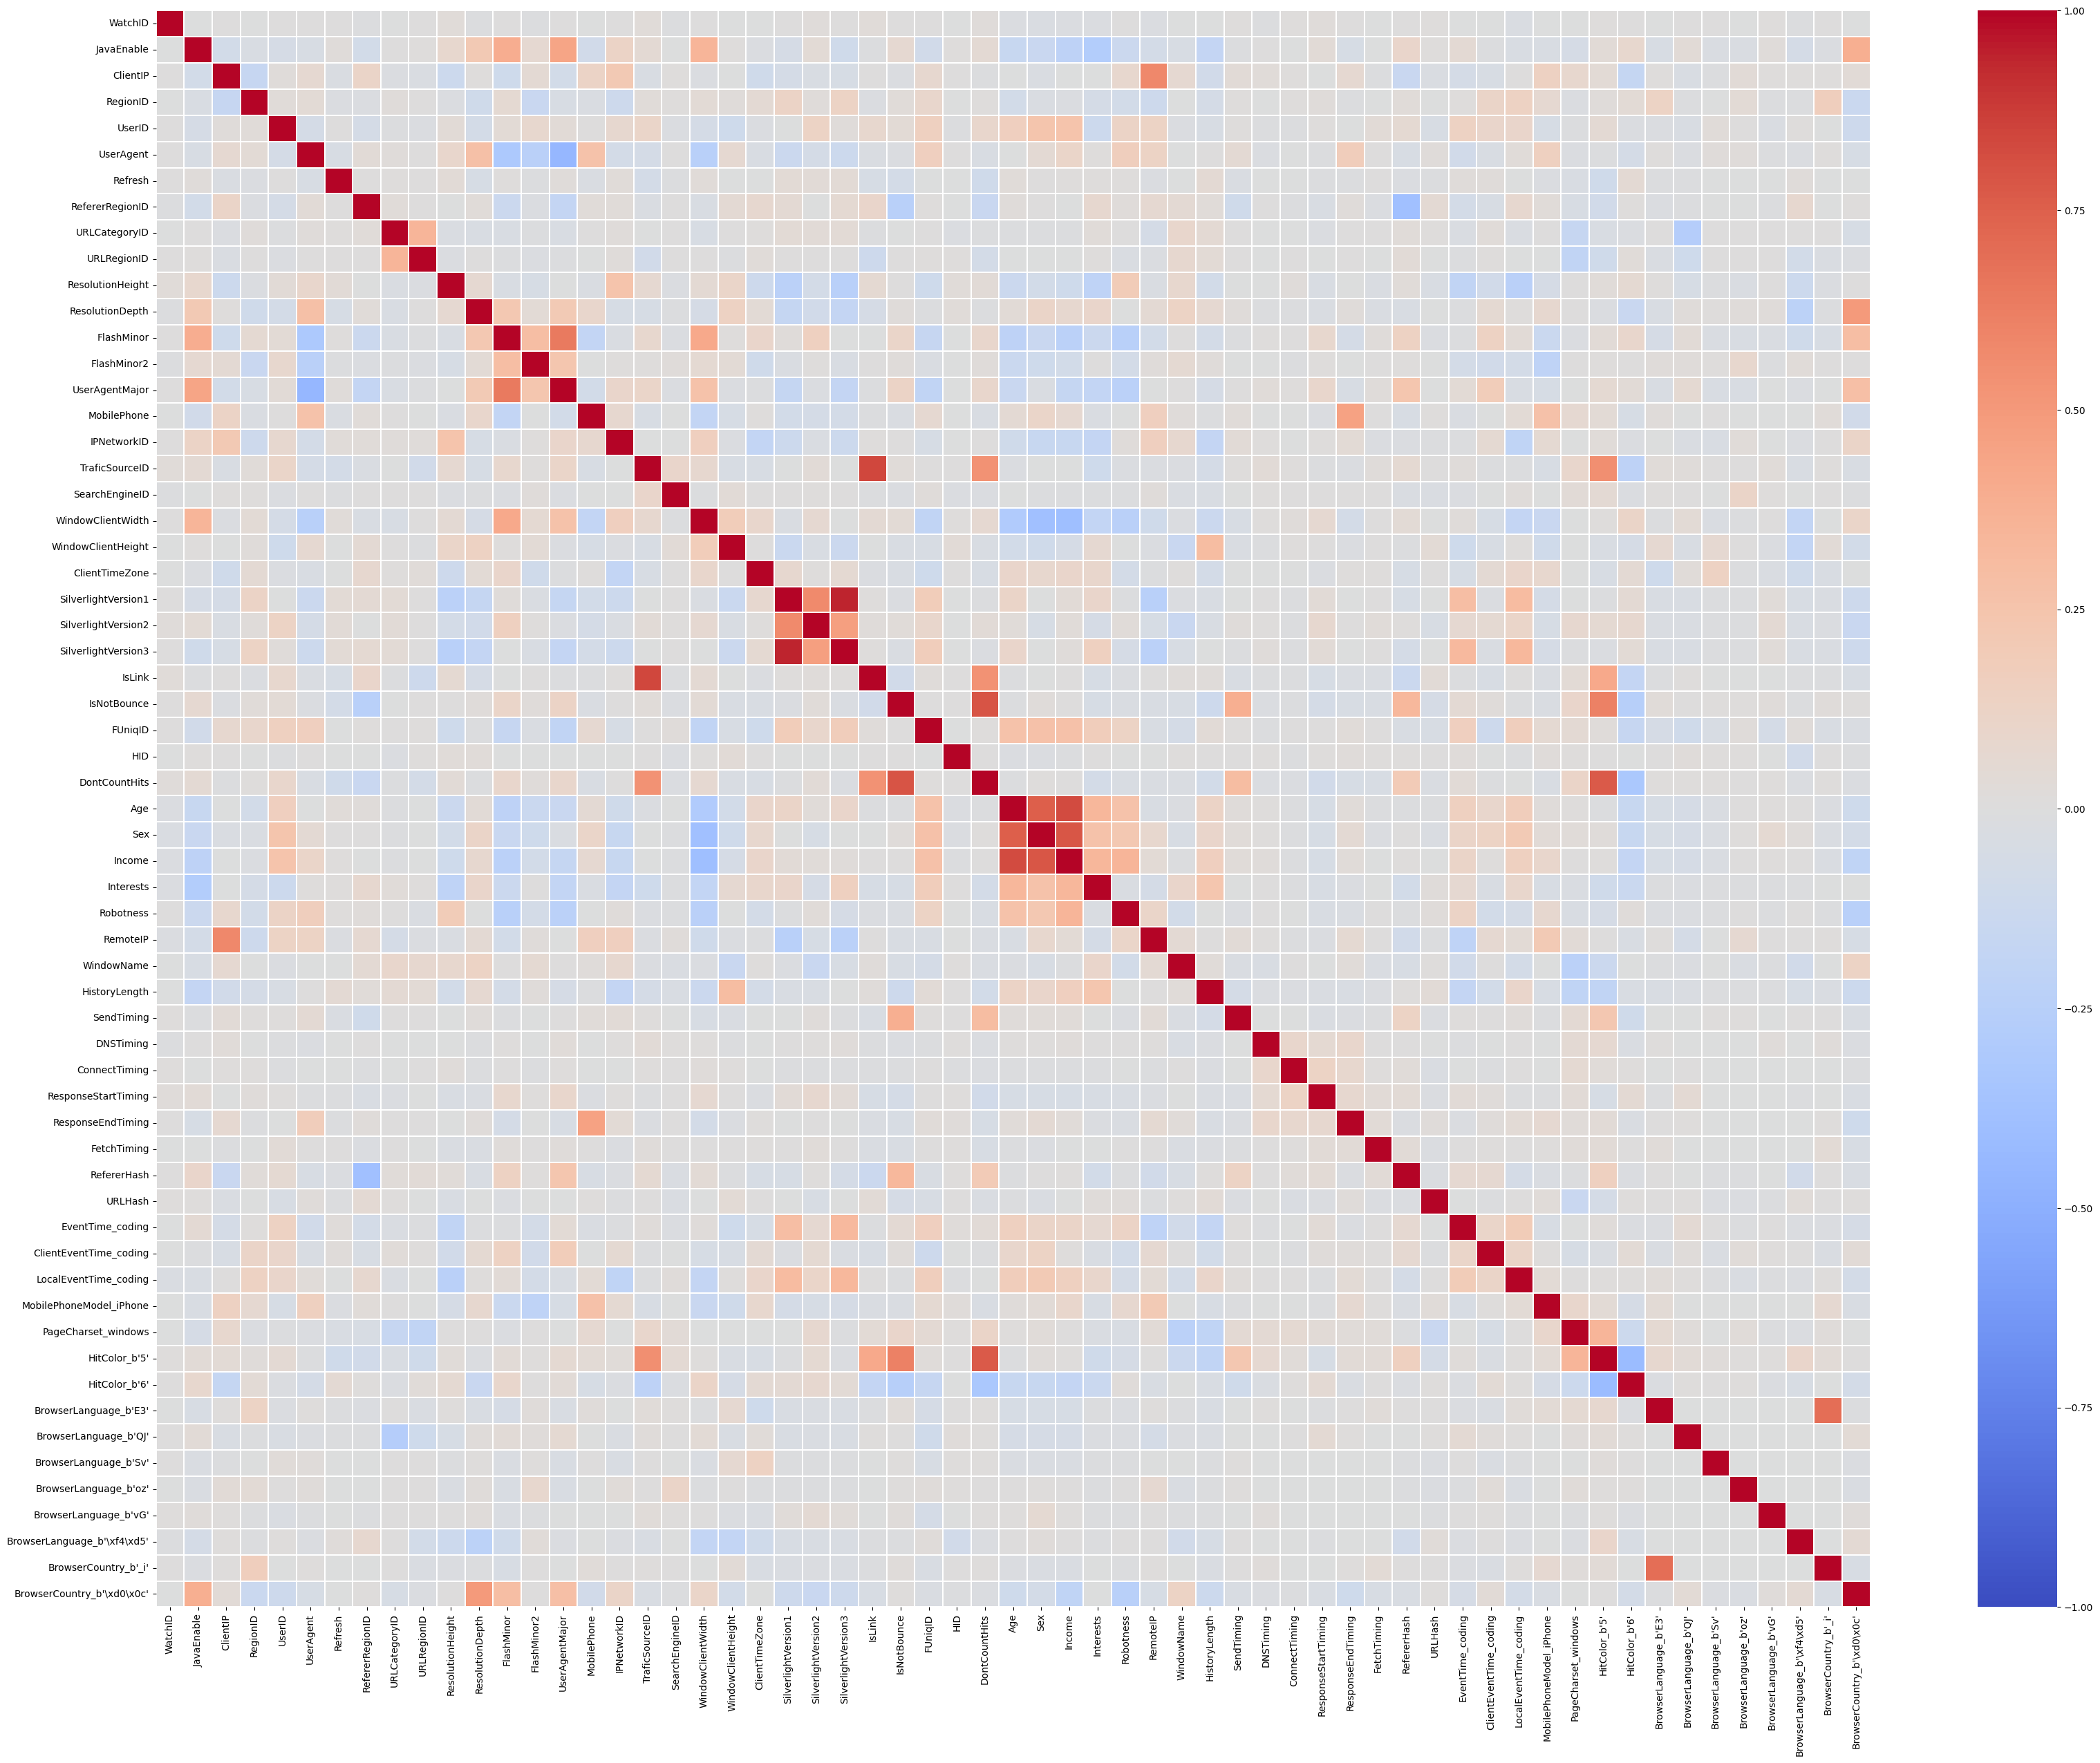

In [155]:
fig, ax = plt.subplots(figsize=(40, 30))
sns.heatmap(df.corr(), linewidths= .3, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [156]:
y = df['DontCountHits']
X = df.drop(columns=['DontCountHits', 'OriginalURL'])

In [157]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   WatchID                      8192 non-null   uint64 
 1   JavaEnable                   8192 non-null   uint8  
 2   ClientIP                     8192 non-null   uint32 
 3   RegionID                     8192 non-null   uint32 
 4   UserID                       8192 non-null   uint64 
 5   UserAgent                    8192 non-null   uint8  
 6   Refresh                      8192 non-null   uint8  
 7   RefererRegionID              8192 non-null   uint32 
 8   URLCategoryID                8192 non-null   uint16 
 9   URLRegionID                  8192 non-null   uint32 
 10  ResolutionHeight             8192 non-null   uint16 
 11  ResolutionDepth              8192 non-null   uint8  
 12  FlashMinor                   8192 non-null   uint8  
 13  FlashMinor2       

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)  # стратифицированное разбиение на тренировочную и тестовую выборки

In [167]:
# обучение решающего дерева, прогнозирование класса и оценка качества модели
decision_tree_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=5, min_samples_leaf=7, class_weight='balanced')
decision_tree_model.fit(X_train, y_train)

y_train_pred = decision_tree_model.predict(X_train)
y_test_pred = decision_tree_model.predict(X_test)
dt_accuracy = metrics.accuracy_score(y_test, y_test_pred)
dt_f1 = metrics.f1_score(y_test, y_test_pred)

print('Метрики на тренировочной выборке: ')
print(classification_report(y_train, y_train_pred))
print('Метрики на тестовой выборке: ')
print(classification_report(y_test, y_test_pred))

Метрики на тренировочной выборке: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4727
           1       0.92      1.00      0.96      1007

    accuracy                           0.98      5734
   macro avg       0.96      0.99      0.97      5734
weighted avg       0.99      0.98      0.98      5734

Метрики на тестовой выборке: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2026
           1       0.90      1.00      0.95       432

    accuracy                           0.98      2458
   macro avg       0.95      0.99      0.97      2458
weighted avg       0.98      0.98      0.98      2458



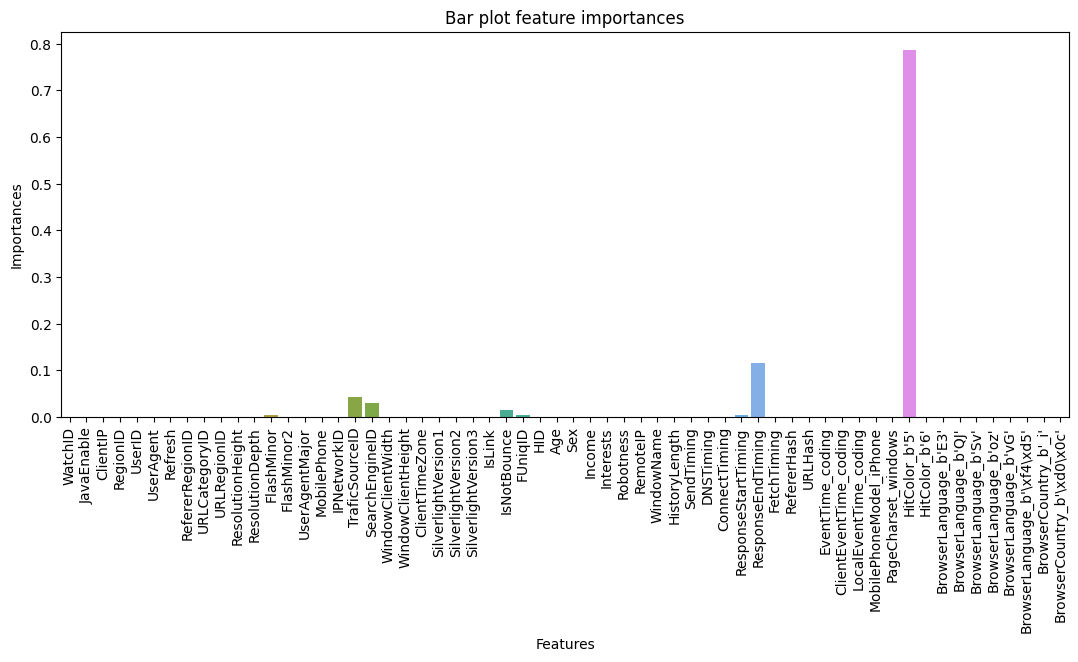

In [168]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = decision_tree_model.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
plt.xticks(rotation=90);

Согласно графику важности признаков в результате реализации дерева решений на признак DontCountHits наибольшее влияние оказывают HitColor (в частности HitColor_b'5'), ResponseEndTiming, ResponseStartTiming, TraficSourceID, SearchEngineID, IsNotBounce, FUniqID и FlashMinor. Также данный признак не зависит от времени согласно графикам scatterplot и boxplot, построенным ранее.